<a href="https://colab.research.google.com/github/Kosarchik/A-B-Tests/blob/main/A_B_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing A/B Testing Results
Source: https://www.kaggle.com/datasets/flkuhm/art-price-dataset

The work was done for training purposes on data from an open source.

The aim of the study is to analyze the results of an A/B test: to determine the effect of the tested changes on the average user order value.

The course of the study:

Evaluate the quality of the collected data from the A/B experiment groups.
Conduct exploratory data analysis: check the data for outliers and anomalies.
Study the results of the research (A/B test), check if statistical criteria indicate differences between the control and test groups.
Data preprocessing.
Import the necessary libraries for solving the research tasks.

The site launched an A/B test in order to increase income. The excel file contains raw data on the results of the experiment (user_id), sample type (variant_name) and income brought by the user (revenue).

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import shapiro
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr


In [3]:
#Let's load the data
df= pd.read_csv('/content/AB_Test_Results.csv')

In [4]:
#The first step to parse the entire dataset is head(), nunique(), info() and describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [6]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [7]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


As you can see an interesting point that minimum 75% of users have no purchases!

Now let's look at user groups. We are trying to see if some users are in two groups

In [8]:
duplicates_users = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
duplicates_users

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [9]:
duplicates_users_percents = (duplicates_users / duplicates_users.sum()) * 100
display('duplicates users in percents (%):', round(duplicates_users_percents, 2))

'duplicates users in percents (%):'

1    75.63
2    24.37
Name: VARIANT_NAME, dtype: float64

We found technical errors in the distribution system: more than 24% of users were in both the control and test groups. It is incorrect to rely on the data of such users, because it affects the results of the study. Let's exclude these users.

In [10]:
users_in_one_group = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
users_in_one_group = users_in_one_group[users_in_one_group]
df = df[df['USER_ID'].isin(users_in_one_group.index)]
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [11]:
pie_chart = px.pie(df, values='USER_ID', names = 'VARIANT_NAME')
pie_chart

The distribution of users is shown above. The values of the two groups are close to 50%.

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

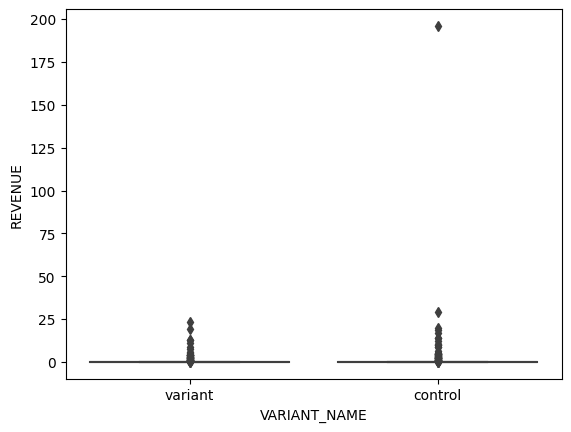

In [12]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

We see an abnormality in the control group. Perhaps this value can be related to the result. So let's try to exclude this user.

In [13]:
df.sort_values(by='REVENUE', ascending=False).head() # Identify an abnormal purchase

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [16]:
df = df.drop([1437], axis = 0)
df.sort_values(by='REVENUE', ascending=False).head() # Delete the abnormality purchase and check the result 

,USER_ID,VARIANT_NAME,REVENUE
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

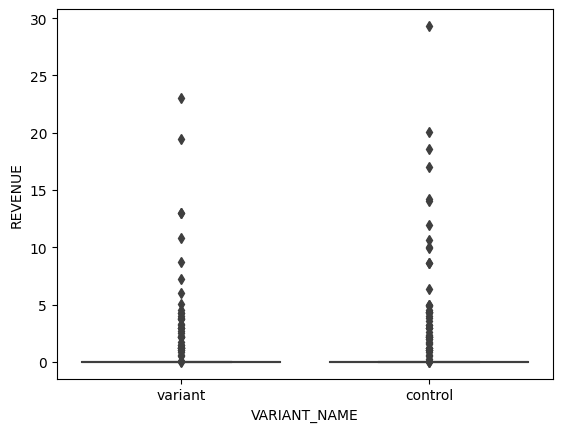

In [17]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In [18]:
df.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3025.0,0.090760,1.034101,0.0,0.0,0.0,0.0,29.32
variant,3044.0,0.058909,0.760344,0.0,0.0,0.0,0.0,23.04


The average value of the control group is 1.5 times greater than the variant group

In [19]:
df.query('REVENUE > 0').groupby('VARIANT_NAME')['REVENUE'].describe() # Let's find users with purchases

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,53.0,5.180189,5.942771,0.02,1.56,2.99,4.98,29.32
variant,43.0,4.170233,4.932851,0.02,1.25,2.72,4.27,23.04


In [20]:
fig = px.histogram(df.query('REVENUE > 0'), x='REVENUE', color='VARIANT_NAME', opacity=0.7)
fig.update_layout(title='Histogram plot of purchases in both groups',
                   xaxis_title='Revenue',
                   yaxis_title='Quantity of purchases',
                   legend_title = 'Groups')


fig.show()

**Define and check statictical hypotezis**
The hypotheses are following:
H0: There is no difference between average order in each group.
H1: Average order in groups is different.

Let's check the value of the statistics of the Mann-Whitney test.



In [21]:
control = df[df['VARIANT_NAME'] == 'control']['REVENUE']
variant = df[df['VARIANT_NAME'] == 'variant']['REVENUE']

In [22]:
display('p-value:', "{0:.3f}".format(st.mannwhitneyu(control, variant)[1]))

'p-value:'

'0.286'

p-value = 0.286 is greater than the significance level alpha = 0.05. So we reject the null hypothesis. There are statistically significant differences in the average cost of the order between the groups.

In [23]:
#Consider the statistical significance of the difference in the average cost of the order by the results of the test
control = df[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0)]['REVENUE']
variant = df[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0)]['REVENUE']

In [24]:
display('p-value', "{0:.3f}".format(st.mannwhitneyu(control, variant)[1]))

'p-value'

'0.422'

p-value = 0.422 more then alpha = 0.05. There are statistically significant differences in the average cost of the order between the groups.

Let's make a bootstraping

In [25]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [26]:
#samples for all users
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [27]:
#samples for paying users 
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Text(0.5, 1.0, ' Distribution for all users')

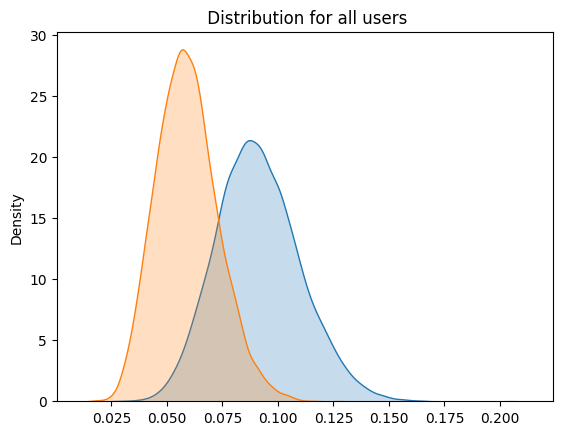

In [28]:
#samples for all users
f, ax = plt.subplots()
sns.kdeplot(np.mean(control, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), fill=True, label='variant')
plt.title(' Distribution for all users')

Text(0.5, 1.0, 'Distribution for paying users')

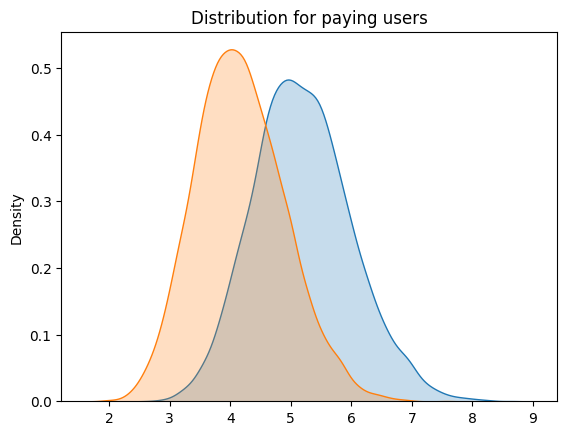

In [29]:
# same for paynig users
f, ax = plt.subplots()
sns.kdeplot(np.mean(control_paid, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), fill=True, label='variant')
plt.title('Distribution for paying users')


Recapitulation:

During the preprocessing of the data from the A/B test results, technical errors were found in the distribution system, and data for users who were included in both experimental groups were excluded.

Statistical hypothesis testing was conducted at a significance level of 0.05.

To test the statistical hypothesis of equality of the mean order value, the non-parametric Wilcoxon-Mann-Whitney test was applied because anomalous values were previously found in the study. The results of the test show that there are statistically significant differences in the mean order value: the metrics of the test group are worse than those of the control group.